In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
print("Loading model...")
model_id = "Qwen/Qwen3-VL-2B-Instruct"
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa", # Changed from flash_attention_2 to sdpa to avoid extra dependencies
    # device_map="auto",
    # Force single-GPU placement
    device_map={"": 0} if torch.cuda.is_available() else None,
    # use_cache=False # Important for training with gradient checkpointing
)
model.enable_input_require_grads()
processor = AutoProcessor.from_pretrained(model_id)
tokenizer = processor.tokenizer
tokenizer.pad_token = tokenizer.eos_token


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model...


In [2]:
import types
import torch

def monkey_patch_qwen_generation(model_instance):
    """
    Monkey patches a Qwen3VLForConditionalGeneration instance to support
    custom position_id passthrough during generation.
    """
    
    # We define the custom method. Note that 'self' will be the model instance.
    def custom_prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        attention_mask=None,
        inputs_embeds=None,
        cache_position=None,
        position_ids=None,
        use_cache=True,
        pixel_values=None,
        pixel_values_videos=None,
        image_grid_thw=None,
        video_grid_thw=None,
        **kwargs,
    ):
        # 1. Distinguish Prefill vs. Decoding
        #    If cache_position[0] is 0, we are in the prefill stage (processing the prompt).
        #    Otherwise, we are generating new tokens.
        is_prefill = cache_position is not None and cache_position[0] == 0

        # 2. Call the parent class's logic (GenerationMixin) to handle standard args
        #    Since we are monkey-patching an instance, we use the class explicitly.
        #    (We use the super of the instance's class to be safe).
        model_inputs = super(type(self), self).prepare_inputs_for_generation(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            cache_position=cache_position,
            position_ids=position_ids,
            pixel_values=pixel_values,
            pixel_values_videos=pixel_values_videos,
            image_grid_thw=image_grid_thw,
            video_grid_thw=video_grid_thw,
            use_cache=use_cache,
            **kwargs,
        )

        # 3. Custom Logic
        if is_prefill:
            # --- PREFILL PHASE ---
            # print("DEBUG: Initial generation (Prefill)")
            
            # Pass everything through exactly as provided.
            # If you provided custom position_ids, they are in model_inputs['position_ids']
            # and will be used by forward().
            pass

        else:
            # --- DECODING PHASE ---
            # print("DEBUG: Decoding step")
            
            # A. Clear heavy visual inputs (standard Qwen optimization)
            model_inputs["pixel_values"] = None
            model_inputs["pixel_values_videos"] = None

            # B. Handle Position IDs
            if position_ids is not None:
                # 1. Take the last column (shape: [3, batch, 1])
                last_pos = position_ids[..., -1:]
                # second_last_pos = position_ids[..., -2:]
                prompt_len = position_ids.shape[-1]
                
                # B. Get the current total sequence length from the cache
                #    (e.g., if prompt is 100, and we generated 5 tokens, this is 105)
                current_seq_len = past_key_values.get_seq_length()
                
                # C. Calculate the delta (how many tokens have we generated?)
                #    Step 1: 100 - 100 = 0
                #    Step 2: 101 - 100 = 1
                delta = current_seq_len - prompt_len
                # 2. Increment it. 
                #    Note: This assumes we just step forward in time/text index. 
                #    Ideally, mRoPE logic for "next token" is just adding 1 to the text dimension.
                #    Since all dimensions usually increment for text in mRoPE, +1 is safe.
                new_pos = last_pos + 1 + delta
                # print(new_pos.shape)
                model_inputs["position_ids"] = new_pos
            else:
                # Fallback if no position_ids tracked (though for your case, this shouldn't happen)
                # print('fallback')
                model_inputs["position_ids"] = None
        # model_inputs["position_ids"] = None
        # print(model_inputs['position_ids'].shape)
        return model_inputs

    # Apply the monkey patch using MethodType to bind it as an instance method
    model_instance.prepare_inputs_for_generation = types.MethodType(
        custom_prepare_inputs_for_generation, model_instance
    )
    
    print(f"Successfully patched {type(model_instance).__name__} instance.")

# Usage:
monkey_patch_qwen_generation(model)

Successfully patched Qwen3VLForConditionalGeneration instance.


In [121]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            # {
            #     "type": "image",
            #     "image": "https://www.cdc.gov/healthy-pets/media/images/2024/04/Cat-on-couch.jpg",
            # },
            {"type": "text", "text": "Describe what you see carefully. how many images are there? what are the scenes? Also who are you?"},

        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)




In [3]:
processor.batch_decode(inputs['input_ids'])

['<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|

In [23]:
torch.where(inputs['input_ids']==processor.vision_end_token_id)

(tensor([0, 0]), tensor([2756, 5510]))

In [16]:
torch.where(inputs['input_ids']==processor.vision_start_token_id)

(tensor([0, 0]), tensor([   3, 2757]))

In [8]:
pos_ids = model.model.get_rope_index(inputs['input_ids'],inputs['image_grid_thw'])[0].cpu().numpy()

In [9]:
pos_ids.shape

(3, 1, 5533)

In [26]:
pos_ids[:,2759]

array([70, 70, 71])

In [28]:
get_rope_index = model.model.get_rope_index

In [91]:
inputs['image_grid_thw']

tensor([[  1,  86, 128],
        [  1,  86, 128]], device='cuda:0')

In [95]:
torch.sum(inputs['input_ids'][0]==processor.image_token_id)

tensor(5504, device='cuda:0')

In [15]:
# from typing import Optional
def get_blended_rope_index(self, input_ids, image_grid_thw, video_grid_thw=None,attention_mask=None):
    device = input_ids.device
    merge_size = self.config.vision_config.spatial_merge_size
    image_token_id = self.config.image_token_id
    video_token_id = self.config.video_token_id
    
    # 1. Pre-calculate the "Gap Size" (Max dimension of the largest visual in batch)
    # This reserves the "Canvas" so text doesn't collide with the largest blended image.
    current_grids = [image_grid_thw]
    if video_grid_thw is not None:
        # Flatten video T just like standard Qwen logic
        flat_vid = video_grid_thw.repeat_interleave(video_grid_thw[:, 0], dim=0)
        flat_vid[:, 0] = 1
        current_grids.append(flat_vid)
    
    combined_grids = torch.cat(current_grids, dim=0)
    max_h = (combined_grids[:, 1] // merge_size).max().item()
    max_w = (combined_grids[:, 2] // merge_size).max().item()
    max_hw_gap = max(max_h, max_w)
    # print(max_hw_gap)
    position_ids = torch.zeros(3, input_ids.shape[0], input_ids.shape[1], dtype=torch.long, device=device)
    mrope_deltas = []

    # 2. Process Batch
    for i, seq_ids in enumerate(input_ids):
        input_tokens = seq_ids.tolist()
        pos_list = []
        
        # Pointers
        img_ptr = 0
        vid_ptr = 0
        cursor = 0
        visual_anchor = None
        
        while cursor < len(input_tokens):
            # Find the next visual payload (Image OR Video token)
            # We search for the first occurrence of EITHER token type
            try:
                next_img = input_tokens.index(image_token_id, cursor)
            except ValueError:
                next_img = float('inf')
            
            try:
                next_vid = input_tokens.index(video_token_id, cursor)
            except ValueError:
                next_vid = float('inf')
            
            next_payload = min(next_img, next_vid)
            
            # --- A. HANDLE TEXT (Everything before the payload) ---
            # This includes <vision_start>, <vision_end>, and actual text.
            if next_payload > cursor:
                # Limit text segment to end of sequence if no more visuals
                end_pos = min(next_payload, len(input_tokens))
                length = end_pos - cursor
                
                # Determine Start Position
                if visual_anchor is None:
                    # Before first image: Standard contiguous diagonal
                    start_pos = pos_list[-1].max().item() + 1 if pos_list else 0
                else:
                    # After/Between images: Jump over the "Gap"
                    # We must be strictly after (Anchor + Max_Size)
                    current_max = pos_list[-1].max().item()
                    safe_start = visual_anchor + max_hw_gap + 1
                    start_pos = max(current_max + 1, safe_start)
                
                # Generate Diagonal IDs (t=h=w)
                diag = torch.arange(length, device=device).view(1, -1).expand(3, -1)
                pos_list.append(diag + start_pos)
                cursor += length
            
            # --- B. HANDLE VISUAL PAYLOAD ---
            if cursor < len(input_tokens):
                token_type = input_tokens[cursor]
                
                # Get Geometry
                if token_type == image_token_id:
                    t, h, w = image_grid_thw[img_ptr]
                    img_ptr += 1
                else:
                    t, h, w = flat_vid[vid_ptr]
                    vid_ptr += 1
                
                llm_h, llm_w = h.item() // merge_size, w.item() // merge_size
                num_tokens = t.item() * llm_h * llm_w
                
                # Set Anchor (Time Freeze)
                if visual_anchor is None:
                    # The anchor is the current available position ID
                    # This freezes the timeline for ALL subsequent images
                    visual_anchor = pos_list[-1].max().item() + 1 if pos_list else 0
                
                # Generate Grid (Always relative to visual_anchor)
                # Use meshgrid('ij') to handle H (row) and W (col) correctly
                grid_h, grid_w = torch.meshgrid(
                    torch.arange(llm_h, device=device),
                    torch.arange(llm_w, device=device),
                    indexing='ij'
                )
                
                h_idx = grid_h.flatten()
                w_idx = grid_w.flatten()
                t_idx = torch.zeros_like(h_idx) # Flattened Qwen images have relative T=0
                
                # If T > 1 (unflattened), we would repeat, but Qwen3 logic flattens first.
                # Just strictly enforcing the shape match:
                if t.item() > 1:
                     h_idx = h_idx.repeat(t.item())
                     w_idx = w_idx.repeat(t.item())
                     t_idx = t_idx.repeat(t.item())

                grid = torch.stack([t_idx, h_idx, w_idx]) + visual_anchor
                pos_list.append(grid)
                
                # Advance cursor past the payload
                cursor += num_tokens

        # 3. Finalize
        full_pos = torch.cat(pos_list, dim=1)
        # Handle case where generated IDs don't match input length (safety)
        valid_len = min(full_pos.shape[1], input_ids.shape[1])
        position_ids[..., i, :valid_len] = full_pos[..., :valid_len]
        
        # Calculate Delta for Generation
        # Logic: Where the cursor IS (visual_anchor + small increment) vs Where memory IS (long sequence)
        delta = full_pos.max().item() + 1 - full_pos.shape[1]
        mrope_deltas.append(delta)

    return position_ids, torch.tensor(mrope_deltas, device=device).unsqueeze(1)

from typing import types
model.model.get_rope_index= types.MethodType(get_blended_rope_index, model)

# get_blended_rope_index



In [5]:
# Enables interactive backend for Jupyter
# %pip install ipympl
# %matplotlib widget
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate dummy 3xN data
data=pos_ids

# 2. Setup figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# 3. Plot (using the c parameter for color mapping based on Z height)
sc = ax.scatter(data[0], data[1], data[2], c=data[2], cmap='viridis',s=0.5)

# 4. Add a colorbar (optional, but looks nice interactively)
plt.colorbar(sc, label='Z Value')

# 5. Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

NameError: name 'pos_ids' is not defined

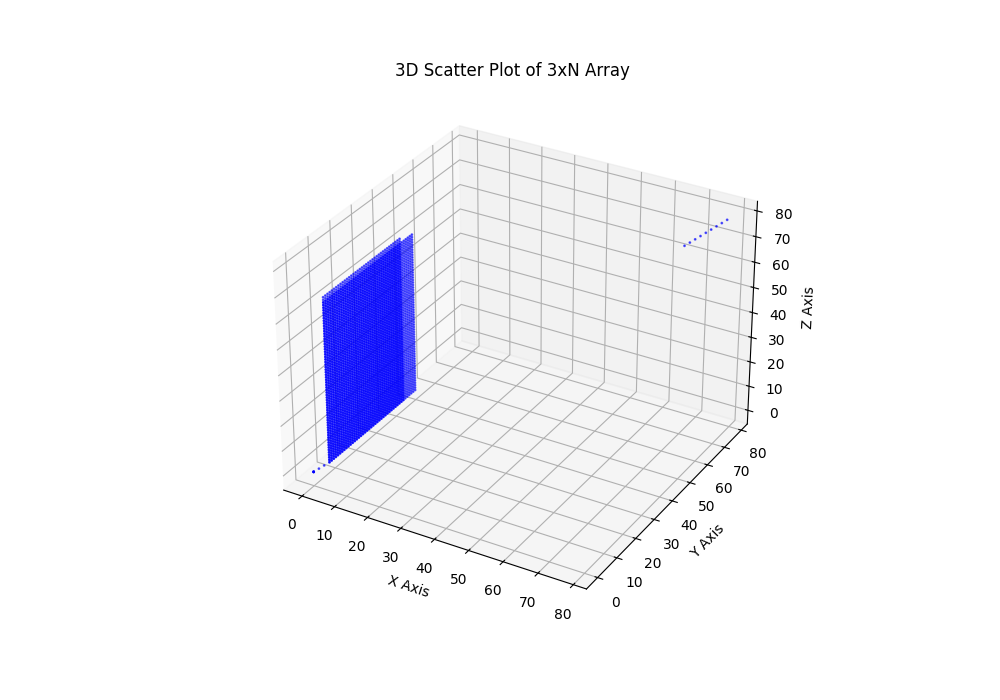

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate dummy 3xN data (3 rows, 100 columns)
# N = 100
data =pos_ids

# 2. Setup the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

# 3. Plot
# We slice the array to get x=row 0, y=row 1, z=row 2
ax.scatter(data[0, :], data[1, :], data[2, :], c='blue', marker='o', alpha=0.6,s=1.0)

# 4. Labels and Title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot of 3xN Array')

plt.show()

In [33]:
%load_ext autoreload
%autoreload 2

In [27]:
inputs['input_ids'].shape[1]
torch.ones(3,1,inputs['input_ids'].shape[1],device=model.device).shape

torch.Size([3, 1, 5533])

In [3]:
from datasets import load_dataset, DatasetDict, Features, Value, Sequence,Image

ds = load_dataset("json", data_files='/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/train_all_pose_depth.jsonl', split="train")
image_root = '/Projects/SG_VLN_HumanData/SG-VLN/data/datasets/objectnav/objectnav_mp3d_thda_70k/objectnav_images_depth'
import os
def make_absolute(example):
    example["rgb_sequence"] = [os.path.join(image_root, p) for p in example["rgb_paths"]]
    example["depth_sequence"] = [os.path.join(image_root,p) for p in example['depth_paths']]
    return example

ds = ds.map(make_absolute, num_proc=16, desc="Fixing Paths")
ds = ds.cast_column('rgb_sequence',Sequence(Image()))

In [5]:
from utils.bev_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
import argparse
import os
import json
from pathlib import Path
from collections import Counter
from datasets import load_dataset, DatasetDict, Features, Value, Sequence
from PIL import Image, UnidentifiedImageError
import textwrap

# ------------------------------------------------------------------------------
# 1. USER PROVIDED LOGIC (Reused)
# ------------------------------------------------------------------------------

def to_convo(example,limit = 20):
   
    # 1. We assume 'images' column exists and is a list of file paths (or objects)
    #    Make sure you access the correct column name (rgb_sequence vs images)
    # image_list = example['rgb_sequence'] 
    import textwrap

    system_prompt = textwrap.dedent(f"""\
    You are a visual navigation agent tasked with finding "{example['goal_text']}" in an unknown environment.
    You will receive a sequence of observations showing your movement history up to the current moment.

    **Action Space:**
    [STOP, MOVE_FORWARD, TURN_LEFT, TURN_RIGHT, LOOK_UP, LOOK_DOWN]

    **Your Mission:**
    1. Analyze the observation history to understand your current location and orientation.
    2. Select the next discrete action to navigate efficiently towards the goal.

    **Critical Constraints:**
    * **Collision Detection:** If your previous action was MOVE_FORWARD but the visual observation did not change significantly, you have collided. You MUST turn or move away immediately. Do not keep pushing forward.
    * **Success Condition:** Output **STOP** ONLY when the target is plainly in view, centered, and within 1 meter (close enough to touch).

    **Output Format:**
    Respond with the selected action inside double asterisks.
    """)
    convo = [
        {"role": "user", "content": [
                # Text Item: explicit None for image
                {"type": "text", "text": system_prompt}, 
        ]},
    ]

    for i, action in enumerate(example['actions']):
        convo += [
             {"role": "user", "content": [
                # Text Item: explicit None for image
                {"type": "text", "text": f"Observation {i}:"}, 

                {"type": "image", "text": None},
                
                # Text Item
                {"type": "text", "text": f"Action {i}:"}
            ]},
            {"role": "assistant", "content": [
                {"type": "text", "text": f"**{action}**"}
            ]} 
        ]
        if i == limit-1:
            break
    example['messages'] = convo
    return example


In [7]:

limit = 30

ep_idx=15
mats = pos_rots_to_matrix(np.array(ds[ep_idx]['pos_rots'])) @ get_cv_to_habitat_correction()
rgbs = np.array(ds[ep_idx]['rgb_sequence'])
depths = load_depths(ds[ep_idx])
divisor = 8
ps = 32 //divisor
points = depth_to_pointcloud(depths,fov_degrees=79)
patch_coords = patch_average_einops(points,patch_size=ps)
patch_coords_world = transform_points_batch(patch_coords,mats)
patch_coords_discrete = (patch_coords_world/0.15).astype(int)

mask = (patch_coords_world[:limit,...,1]<2)
rgb_patches = patch_average_einops(rgbs.astype(float),patch_size=ps)
# mask = np.ones(patch_coords_world.shape[:-1],dtype=bool)
print(mask.shape)
pcd = create_colored_pointcloud(patch_coords_world[:limit][mask],rgb_patches[:limit][mask])
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

(30, 120, 160)


True

In [18]:
ep_idx=15
mats = pos_rots_to_matrix(np.array(ds[ep_idx]['pos_rots'])) @ get_cv_to_habitat_correction()
rgbs = np.array(ds[ep_idx]['rgb_sequence'])
depths = load_depths(ds[ep_idx])
divisor = 1
ps = 32 //divisor
points = depth_to_pointcloud(depths,fov_degrees=79)
patch_coords = patch_average_einops(points,patch_size=ps)
patch_coords_world = transform_points_batch(patch_coords,mats)
patch_coords_discrete = (patch_coords_world/0.15).astype(int)



example = to_convo(ds[ep_idx],limit)
text_prompt = processor.apply_chat_template(
    example['messages']+[
             {"role": "user", "content": [
                # Text Item: explicit None for image
                {"type": "text", "text": f"Good job so far. Now let me test your understanding. Where is the bed relative to the sofa? What is the shape of the sofa? What objects are between the bed and sofa, if any?"}, 
            ]},
        ],
    tokenize=False,
    add_generation_prompt=True
)

# 2. Process inputs (text + images)
inputs = processor(
    text=[text_prompt],
    images=example['rgb_sequence'][:limit], # or actual images
    return_tensors="pt",
    padding=True
)

import torch
pc_pt = torch.tensor(patch_coords_discrete)[:limit]
maps=get_thw(pc_pt)
pos_ids = get_pos_id(inputs['input_ids'],maps.unsqueeze(0),processor)

inputs['position_ids']=pos_ids


NameError: name 'torch' is not defined

In [312]:
generated_ids = model.generate(**inputs.to(model.device), max_new_tokens=1024)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


import textwrap

wrapped_text = textwrap.fill(output_text[0], width=150)
print(wrapped_text)

The observations are a **hybrid** view, combining elements of both ego view and birds eye view.
Here's the justification:  - **Ego View Elements**: The perspective is centered on the agent's
viewpoint, which is consistent with the first-person perspective of the agent's movement. The agent
is moving forward and turning left, and the camera's position is relative to the agent's body. The
view includes the agent's own body and the surrounding environment, which is a common characteristic
of ego views.  - **Birds Eye View Elements**: The perspective is not strictly from above, but rather
from a slightly elevated and angled position, which is typical of a birds eye view. The view is not
directly overhead, but rather from a slightly elevated angle, which is a common characteristic of
birds eye views. The view includes a wide range of the environment, including the agent's movement
and the surrounding environment.  In summary, the observations are a hybrid view that combines the
first-person

In [296]:
rgb_patches = patch_average_einops(rgbs.astype(float),patch_size=ps)
canvas = create_bev_mosaic(rgbs[:limit], patch_coords_discrete[:limit], patch_size=ps)
from PIL import Image

img = Image.fromarray(canvas)
img.save('bev.png')

In [297]:
mask = (patch_coords_world[:limit,...,1]<2)
# mask = np.ones(patch_coords_world.shape[:-1],dtype=bool)
print(mask.shape)
pcd = create_colored_pointcloud(maps.T.reshape(list(mask.shape)+[3])[mask],rgb_patches[:limit][mask])
path = Path("test_pcd.ply")
path.parent.mkdir(parents=True, exist_ok=True)

o3d.io.write_point_cloud(str(path), pcd)

(30, 15, 20)


True

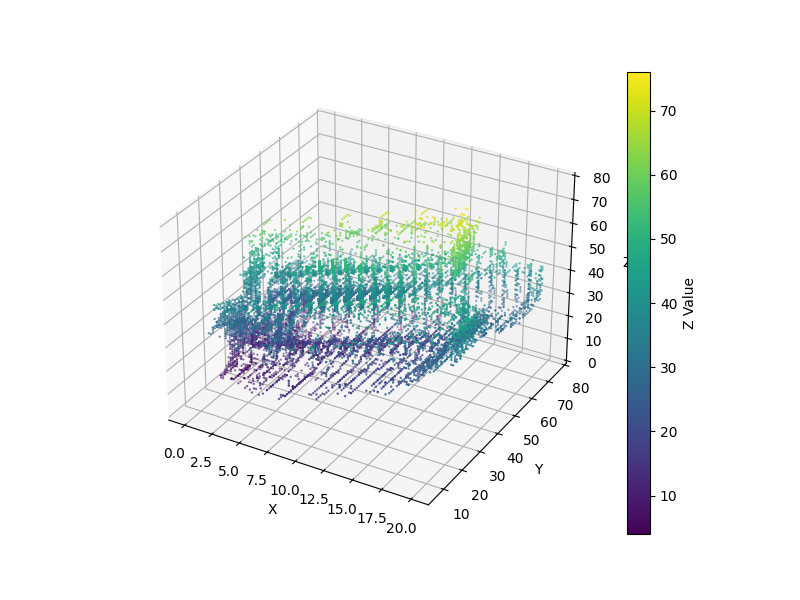

In [294]:
# Enables interactive backend for Jupyter
# %pip install ipympl
# %matplotlib widget
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate dummy 3xN data
data=maps#get_pos_id(inputs['input_ids'],maps.unsqueeze(0),processor,canvas_size=30).cpu().numpy()

# 2. Setup figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# 3. Plot (using the c parameter for color mapping based on Z height)
sc = ax.scatter(data[0], data[1], data[2], c=data[2], cmap='viridis',s=0.5)

# 4. Add a colorbar (optional, but looks nice interactively)
plt.colorbar(sc, label='Z Value')

# 5. Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [300]:


# pos_ids = model.model.get_rope_index(inputs['input_ids'],inputs['image_grid_thw'])[0]
# pos_ids = None
# pos_ids = torch.linspace(0,inputs['input_ids'].shape[1],inputs['input_ids'].shape[1],device=model.device,dtype=int).repeat(3,1,1)
def permute_tensor_contents(x):
    # 1. Generate a random permutation of indices for the total number of elements
    idx = torch.randperm(x.numel(), device=x.device)
    
    # 2. Flatten, reorder using the indices, and reshape back
    return x.view(-1)[idx].view(x.shape)

# pos_ids = permute_tensor_contents(pos_ids)

# pos_ids = torch.ones_like(inputs['input_ids']).repeat(3,1,1)
# Inference: Generation of the output
generated_ids = model.generate(**inputs.to(model.device), max_new_tokens=200)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

["The data organization so far is a sequence of observations, where each observation is a visual snapshot of the environment. The observations are taken in a specific order, and each observation is a 2D image of the environment. The images are not necessarily in chronological order, but the sequence of observations is meant to represent the agent's movement through the environment. The agent's actions are also recorded in the sequence, and the actions are performed in the order they are listed."]


In [125]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Suppose the cat is afraid of the mouse. Is this a typical scenario?"},

        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)

tensor([[[  4,  41,  30,  ...,  77, 108,  46]],

        [[ 70,  60,   4,  ...,  27, 101,  70]],

        [[ 70,  70,  93,  ...,  67,  92,  41]]], device='cuda:0')